# Gold marker segmentation with QSM

## Imports

In [1]:
import fastai
from glob import glob
import fastai.vision.learner
import fastai.vision.models
import fastai.data.core
import fastai.callback.all
import fastai.losses
import fastcore.dispatch
import fastcore.basics
import numpy as np
import nibabel as nib
import torch
import cv2
from matplotlib import pyplot as plt

## Prepare data
### Locate input data

The files are 3D NIfTI images.

In [2]:
# Input data
qsm_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*qsm.nii*"))
seg_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*segmentation*clean*seeds.nii*"))
t2s_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*t2starmap.nii*"))
mag_files = sorted(glob("data/bids/sub-*/ses-*/extra_data/*magnitude_combined.nii*"))
assert(len(qsm_files) == len(seg_files) == len(t2s_files) == len(mag_files))
print(f"{len(qsm_files)} NIfTI image sets found in data/bids (QSM, segmentations, T2*, magnitude).")

10 NIfTI image sets found in data/bids (QSM, segmentations, T2*, magnitude).


### Identify the slices where segmentations exist

In [3]:
# array of slice indices where segmentations exist
def get_seg_indices(seg_path):
    seg = nib.load(seg_path).get_fdata()
    seg_indices = np.unique(np.where(seg > 0)[2])
    return seg_indices
 
# samples[sample_num] == [image_num, slice_num]
def get_samples(qsm_files, seg_files):
    samples = []
    sample_count = 0
    for image_num in range(len(qsm_files)):
        seg_indices = get_seg_indices(seg_files[image_num])
        for seg_index in seg_indices:
            samples.append([qsm_files[image_num], seg_files[image_num], seg_index])
    return samples

In [4]:
samples = np.array(get_samples(qsm_files, seg_files))
samples = np.random.permutation(samples)
cut = int(0.8 * len(samples))
train_samples, valid_samples = samples[:cut], samples[cut:]
print(f"{len(train_samples)} training samples and {len(valid_samples)} validation samples selected.")

54 training samples and 14 validation samples selected.


In [5]:
print("Training sample #1:", train_samples[0])
print("Validation sample #1:", valid_samples[0])

Training sample #1: ['data/bids/sub-z2980672/ses-20211020/extra_data/sub-z2980672_ses-20211020_run-01_qsm.nii'
 'data/bids/sub-z2980672/ses-20211020/extra_data/sub-z2980672_ses-20211020_run-01_segmentation_clean_seeds.nii'
 '27']
Validation sample #1: ['data/bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_qsm.nii'
 'data/bids/sub-z0034542/ses-20220715/extra_data/sub-z0034542_ses-20220715_run-01_segmentation_clean_seeds.nii'
 '31']


### Load samples as a PyTorch dataset and fastai 'dataloaders'

In [6]:
class QSM_2D_With_Seg(torch.utils.data.Dataset):
    def __init__(self, sample_details, transform=None):
        self.sample_details = sample_details
        self.transform = transform
        self.c = 2

    def __len__(self):
        return len(self.sample_details)

    def __getitem__(self, idx):
        # convert idx to list if tensor
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # convert idx to image and slice numbers
        qsm_path, seg_path, slice_id = self.sample_details[idx]

        # load data and scale from estimated range of -8,+8 to 0,1
        qsm = (nib.load(qsm_path).get_fdata()[:,:,int(slice_id)]+8) / (8*2)
        seg = (nib.load(seg_path).get_fdata()[:,:,int(slice_id)])

        # resize images to common size
        
        qsm = torch.Tensor(cv2.resize(qsm, dsize=(224, 224)))
        seg = torch.Tensor(cv2.resize(seg, dsize=(224, 224)))

        # expand QSM over 3 channels for RGB models
        qsm = qsm.expand(3, 224, 224)
        
        # apply any necessary transformations
        if self.transform:
            qsm = self.transform(qsm)
            seg = self.transform(seg)

        return fastai.torch_core.TensorImage(qsm), fastai.torch_core.TensorMask(seg)

    def __iter__(self):
        for idx in range(len(self.sample_details)):
            yield self.__getitem__(idx)

In [7]:
train_ds = QSM_2D_With_Seg(train_samples)#, transform=fastai.vision.augment.Resize((146, 160)))
valid_ds = QSM_2D_With_Seg(valid_samples)#, transform=fastai.vision.augment.Resize((146, 160)))
dls = fastai.data.core.DataLoaders.from_dsets(train_ds, valid_ds, batch_size=8, device='cuda:0')

In [8]:
# print some information
batch = dls.one_batch()
print(f"length: {len(batch)}")
print(f"type(batch): {type(batch)}")
print(f"batch[0].shape: {dls.one_batch()[0].shape}")
print(f"batch[1].shape: {dls.one_batch()[1].shape}")
print(f"type(batch[0])): {type(batch[0])}")
print(f"type(batch[1])): {type(batch[1])}")
print(f"dls.device: {dls.device}")

length: 2
type(batch): <class 'tuple'>
batch[0].shape: (8, 3, 224, 224)
batch[1].shape: (8, 224, 224)
type(batch[0])): <class 'fastai.torch_core.TensorImage'>
type(batch[1])): <class 'fastai.torch_core.TensorMask'>
dls.device: cuda:0


In [9]:
@fastcore.dispatch.typedispatch
def show_batch(x:torch.Tensor, y:torch.Tensor, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    nrows = nrows or ((len(samples) + 1) // ncols)
    ncols=max(1, min(ncols, len(samples)))
    
    f, axarr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    for row in range(nrows):
        for col in range(ncols):
            axarr[row,col].axis('off')
            if row * ncols + col < len(x):
                axarr[row,col].set_title(f'Slice {row * ncols + col + 1}')
                alpha = np.array(1.0*np.array(np.array(y[row*ncols+col][0,:,:], dtype=int) != 0, dtype=int))
                axarr[row,col].imshow(np.array(x[row * ncols + col][0,:,:]), cmap='gray', vmin=0.4, vmax=+0.6, interpolation='nearest')
                axarr[row,col].imshow(np.array(y[row * ncols + col][0,:,:]), cmap='Set1', alpha=alpha, vmin=0, vmax=9, interpolation='nearest')
    plt.show()
    f.tight_layout()
    return ctxs

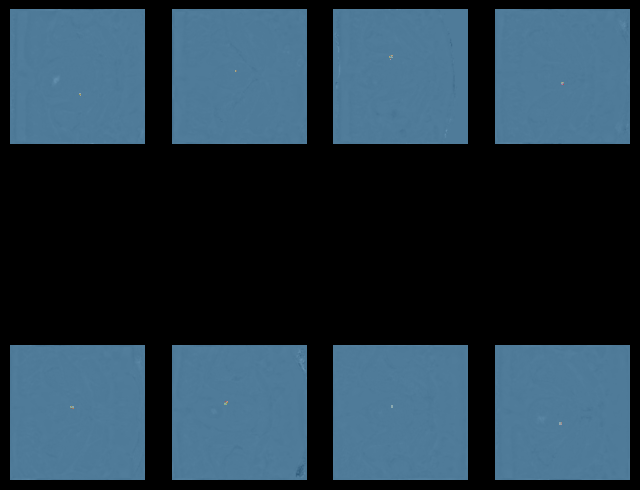

In [10]:
dls.show_batch(figsize=(8,8))

## Prepare learner

In [11]:
# build a unet learner from dls and arch
learn = fastai.vision.learner.unet_learner(
    dls=dls,                            # data loader
    arch=fastai.vision.models.resnet34, # model architecture
    #n_out=2,                            # number of final filters (by default inferred from dls where possible)
    loss_func=fastai.losses.CrossEntropyLossFlat(), # loss function for evaluation during training
    #metrics=dice_score,                 # performance measure for humans (and model selection?)
    model_dir='models',                  # save directory for trained model
    #cbs=[fastai.callback.all.SaveModelCallback(monitor='dice_score', with_opt=True)] # saves the model's best during training and loads it at the end
)
#learn = learn.to_fp16() # use half-precision floats for the learner

In [12]:
learn.summary()

DynamicUnet (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [13]:
inp, pred, target = learn.get_preds(with_input = True)

ValueError: Expected input batch_size (3584) to match target batch_size (401408).

In [ ]:
learn.fit(n_epoch=1)